### Bibliotecas

In [157]:
# tratamento de dados
import pandas as pd
import numpy as np

# dataviz
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

### Importando os dados

In [2]:
# lendo os dados
df_petroleo = pd.read_csv(r'https://raw.githubusercontent.com/torvess/Tech_Challeng_FIAP_Fase_04/refs/heads/main/Dados/dados_petroleo.csv')

In [3]:
# conhecendo os dados
print(f'Número de linhas: {df_petroleo.shape[0]:,}')
print(f'Número de colunas: {df_petroleo.shape[1]}')

print('                                          ')

print(f'Data mínima: {df_petroleo.data.min()}')
print(f'Data máxima: {df_petroleo.data.max()}')

Número de linhas: 11,278
Número de colunas: 2
                                          
Data mínima: 1987-05-20
Data máxima: 2024-10-15


In [4]:
df_petroleo.head(3)

,data,preco
0,2024-10-15,73.68
1,2024-10-12,78.47
2,2024-10-11,80.27


In [5]:
# nenhum valor nulo
df_petroleo.isnull().sum().sum()

0

In [6]:
# nenhum valor duplicado
df_petroleo.duplicated().sum().sum()

0

In [7]:
# verificando os tipos de dados
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11278 entries, 0 to 11277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    11278 non-null  object 
 1   preco   11278 non-null  float64
dtypes: float64(1), object(1)
memory usage: 176.3+ KB


In [8]:
df_petroleo['data'] = pd.to_datetime(df_petroleo['data'], format='%Y-%m-%d')

### Análise exploratória dos dados

In [9]:
# criando um df para fazer alteraçoes
dados_petroleo = df_petroleo.copy()

In [10]:
dados_petroleo.head(3)

,data,preco
0,2024-10-15,73.68
1,2024-10-12,78.47
2,2024-10-11,80.27


In [11]:
dias_da_semana = {
    0: 'segunda-feira',
    1: 'terça-feira',
    2: 'quarta-feira',
    3: 'quinta-feira',
    4: 'sexta-feira',
    5: 'sábado',
    6: 'domingo'
}

# criando colunas necessarias para a analise
dados_petroleo = dados_petroleo.assign(
                                    semana_ano = dados_petroleo.data.dt.isocalendar().week,
                                    dia_semana = dados_petroleo.data.dt.isocalendar().day,
                                    nome_dia = dados_petroleo.data.dt.isocalendar().day.apply(lambda x: dias_da_semana.get(x)),
                                    ano = dados_petroleo.data.dt.isocalendar().year,
                                    mes = dados_petroleo.data.dt.month,
                                    nome_mes = dados_petroleo.data.dt.strftime('%B')
                                        )

# reordenando as colunas
dados_petroleo = dados_petroleo[['ano', 'mes', 'nome_mes', 'semana_ano', 'dia_semana', 'nome_dia', 'data', 'preco']]

In [12]:
dados_petroleo.head(2)

,ano,mes,nome_mes,semana_ano,dia_semana,nome_dia,data,preco
0,2024,10,October,42,2,quarta-feira,2024-10-15,73.68
1,2024,10,October,41,6,domingo,2024-10-12,78.47


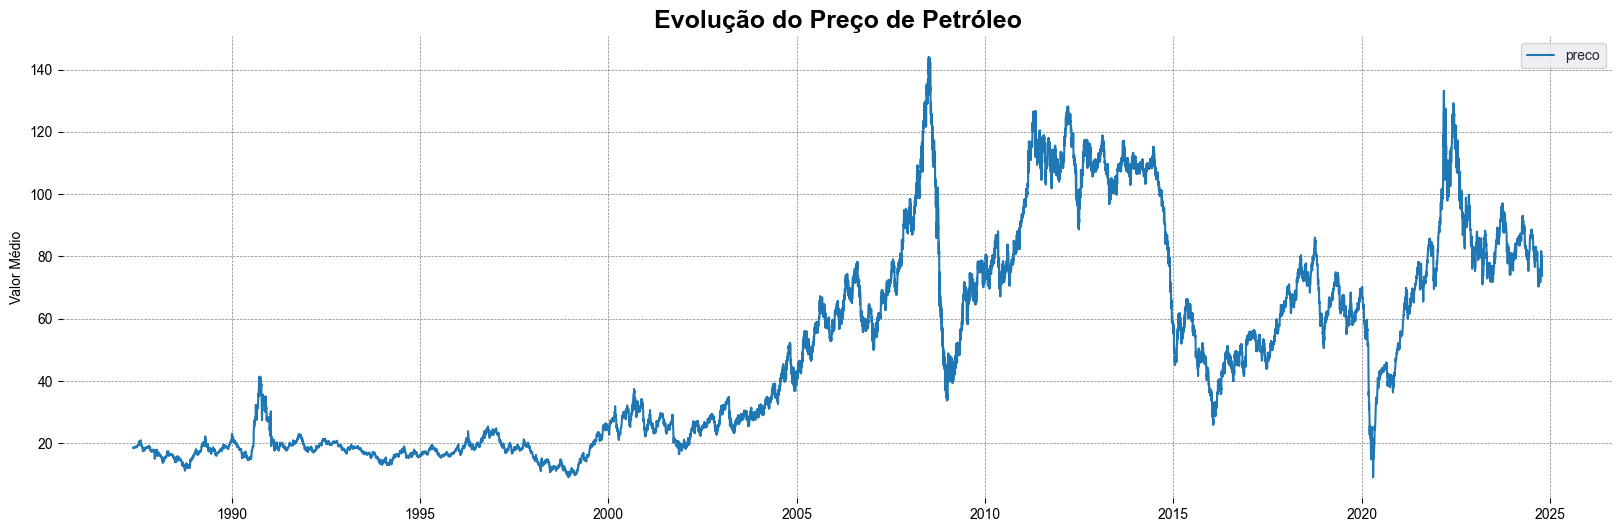

In [13]:
# tamanho da figura
fig, ax = plt.subplots(figsize=(20, 6))
# tema do fundo
sns.set_style("darkgrid")
# formatando os grids
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# plotando informaçoes do grafico
ax = sns.lineplot(data=dados_petroleo.groupby('data').agg({'preco':'mean'}))
ax.set_title('Evolução do Preço de Petróleo', fontsize=18, weight='bold')
ax.set_ylabel('Valor Médio')
ax.set_xlabel('')

plt.show()

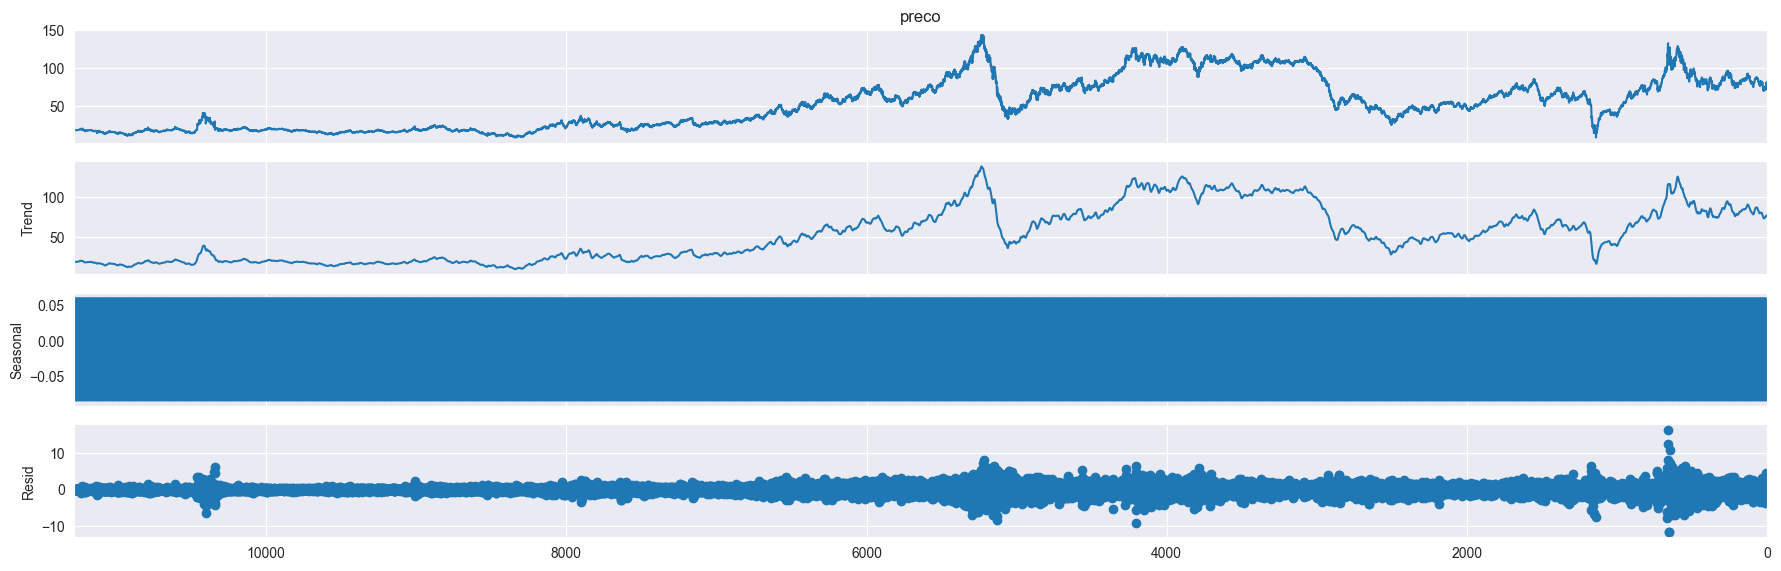

In [14]:
dados_petroleo = dados_petroleo.sort_values(by='data')
decomposicao = seasonal_decompose(dados_petroleo['preco'], model='additive', period=12)

fig = decomposicao.plot()
fig.set_size_inches(20, 6)
plt.show()

Analisando a serie no decorrer do tempo, tivemos tendências contrarias em períodos diferentes.

* Entre 2005 e 2009 forte tendência de aumento de preços seguido por uma queda brusca
* Entre 2010 e 2012 novo aumento seguido por 3 anos sem queda ou novos aumentos
* 2015 novos aumentos que seguiram até 2020
* Entre 2020 e 2023 nova tendência de aumento seguido por queda


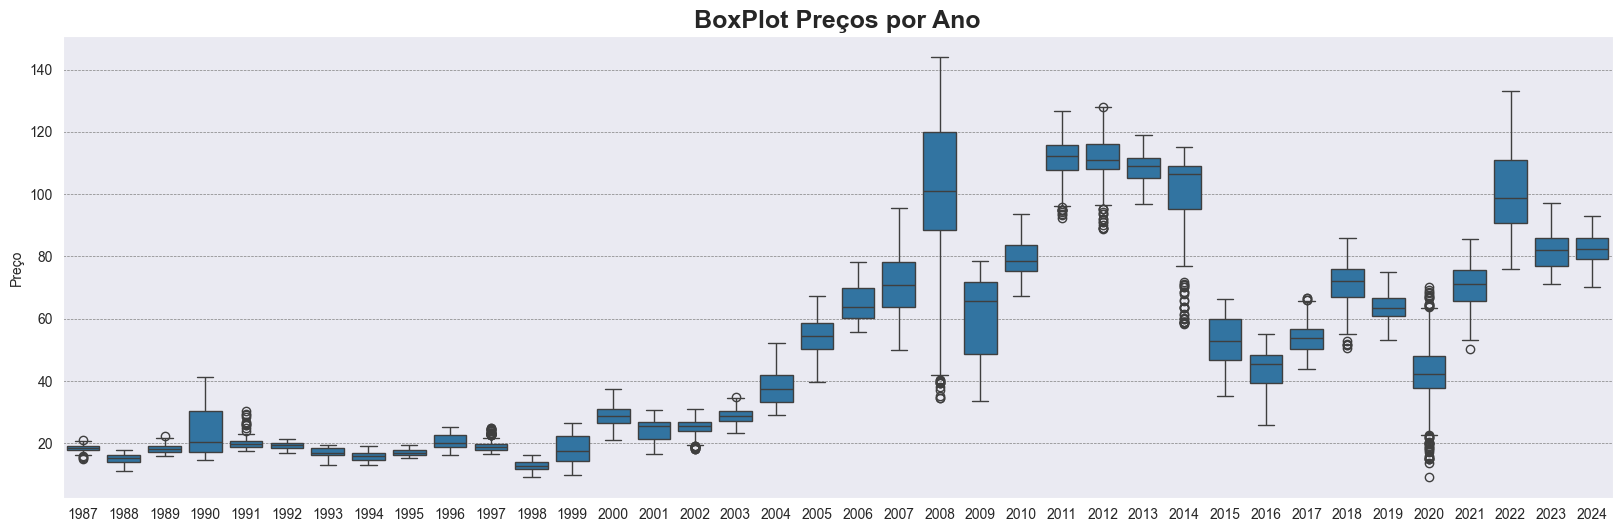

In [15]:
# tamanho da figura
fig, ax = plt.subplots(figsize=(20, 6))
# tema do fundo
sns.set_style("darkgrid")
# formatando os grids
plt.grid(color='gray', linestyle='--', linewidth=0.5)

ax = sns.boxplot(data=dados_petroleo, x='ano', y='preco')
ax.set_title('BoxPlot Preços por Ano', fontsize=18, weight='bold')
ax.set_ylabel('Preço')
ax.set_xlabel('')

plt.show()

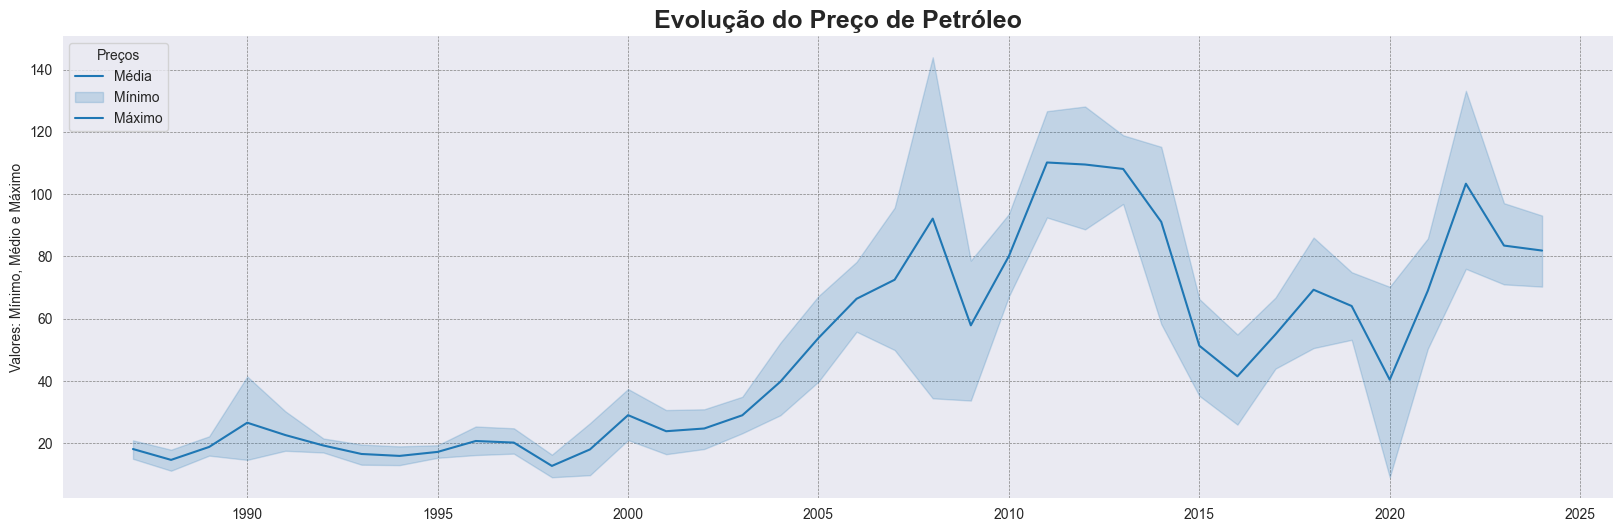

In [16]:
# tamanho da figura
fig, ax = plt.subplots(figsize=(20, 6))
# tema do fundo
sns.set_style("darkgrid")
# formatando os grids
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# plotando o grafico
ax = sns.lineplot(data=dados_petroleo.groupby('ano').agg({'preco' : ['mean', 'min', 'max']}))
ax.set_title('Evolução do Preço de Petróleo', fontsize=18, weight='bold')
ax.set_ylabel('Valores: Mínimo, Médio e Máximo')
ax.set_xlabel('')

# Adicionando a legenda
ax.legend(title='Preços', labels=['Média', 'Mínimo', 'Máximo'], loc='upper left')

plt.show()


### Seleção das features

In [25]:
# copia para preservar o df
dados_ml = dados_petroleo.copy()

# seleção de colunas numéricas
dados_ml = dados_ml[['ano', 'mes', 'semana_ano', 'dia_semana','data', 'preco']]

dados_ml.head(2)

,ano,mes,semana_ano,dia_semana,data,preco
11277,1987,5,21,3,1987-05-20,18.63
11276,1987,5,21,4,1987-05-21,18.45


In [36]:
# Teste ADF
adf_result = adfuller(dados_ml['preco'].dropna())
# Resultados do teste ADF
print("Teste ADF:")
print(f"Estatística: {adf_result[0]}")
print(f"p-valor: {adf_result[1]}")
print(f"Número de lags utilizados: {adf_result[2]}")
print(f"Número de observações: {adf_result[3]}")
print("Valores críticos:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

Teste ADF:
Estatística: -2.126674450552797
p-valor: 0.23392480467400895
Número de lags utilizados: 31
Número de observações: 11246
Valores críticos:
   1%: -3.4309316106391305
   5%: -2.86179704044158
   10%: -2.5669068175153567


Com base no p-valor (0,23) e na comparação da estatística do teste com os valores críticos:

* Não rejeitamos a hipótese nula (H0).
* Conclusão: A série temporal não é estacionária.

In [37]:
# Teste KPSS
kpss_result = kpss(dados_ml['preco'].dropna(), regression="c")
print("\nTeste KPSS:")
print(f"Estatística: {kpss_result[0]}")
print(f"p-valor: {kpss_result[1]}")
print(f"Número de lags utilizados: {kpss_result[2]}")
print("Valores críticos:")
for key, value in kpss_result[3].items():
    print(f"   {key}: {value}")


Teste KPSS:
Estatística: 10.653785365634231
p-valor: 0.01
Número de lags utilizados: 61
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


Conclusão:
Com base no p-valor (0.01) e na comparação da estatística do teste com os valores críticos:

* Rejeitamos a hipótese nula (H0).
* Conclusão: A série temporal não é estacionária.

Visto que a série não é estacionária vou remover tendência e fazer uma diferenciação

In [118]:
# criando df estacionario
dados_ml_est = dados_ml[['data', 'preco']].dropna()

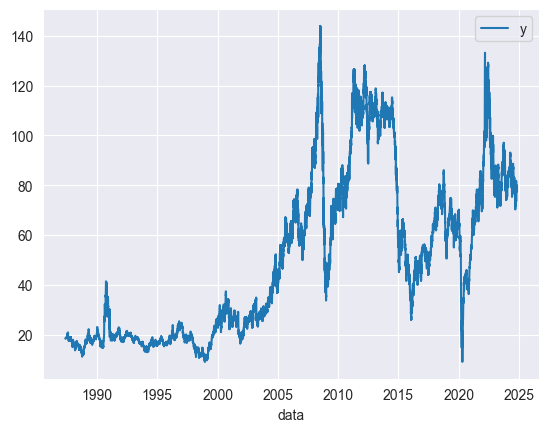

In [119]:
dados_ml_est = dados_ml_est.set_index('data')
dados_ml_est.rename(columns={'preco':'y'}, inplace=True)

sns.lineplot(data=dados_ml_est)
plt.show()

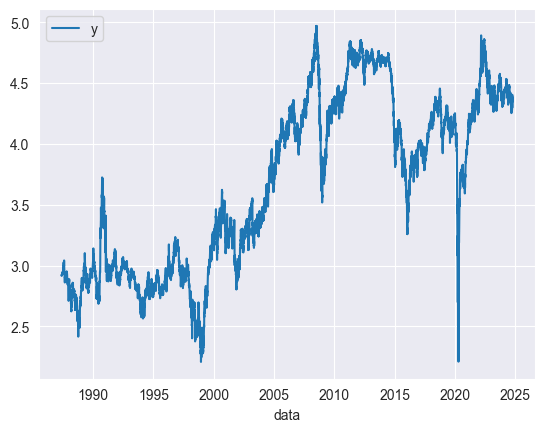

In [97]:
# aplicando escala logaritma
dados_ml_est['y'] = np.log(dados_ml_est['y'])

sns.lineplot(data=dados_ml_est)
plt.show()

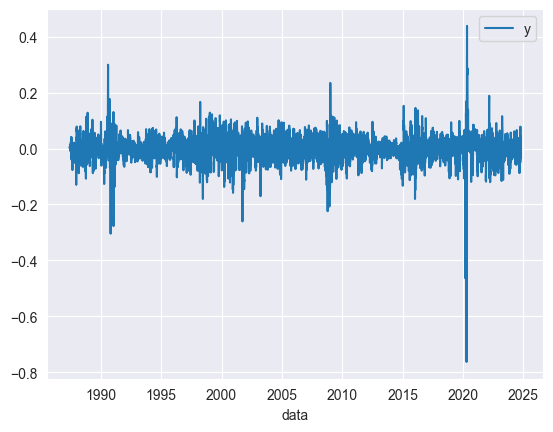

In [98]:
# removendo média móvel
dados_ml_est['y'] = dados_ml_est['y'] - dados_ml_est['y'].rolling(window=12).mean()

sns.lineplot(data=dados_ml_est)
plt.show()

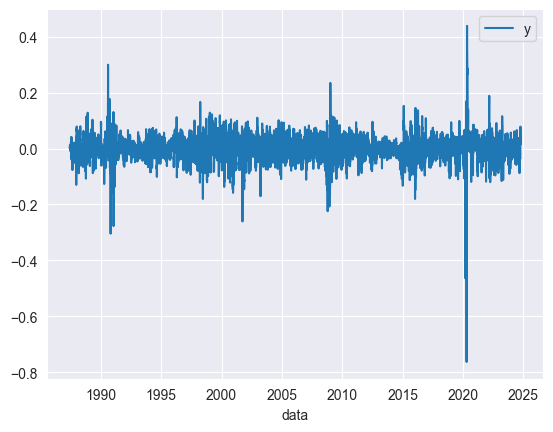

In [99]:
# aplicando diferenciação
dados_ml_est['y'] = dados_ml_est['y'] - dados_ml_est['y'].diff(1)

sns.lineplot(data=dados_ml_est)
plt.show()

Avaliando se está estacionária

In [100]:
# Teste ADF
adf_result = adfuller(dados_ml_est.dropna())
# Resultados do teste ADF
print("Teste ADF:")
print(f"Estatística: {adf_result[0]}")
print(f"p-valor: {adf_result[1]}")
print(f"Número de lags utilizados: {adf_result[2]}")
print(f"Número de observações: {adf_result[3]}")
print("Valores críticos:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

Teste ADF:
Estatística: -17.78118154072766
p-valor: 3.2765903292130296e-30
Número de lags utilizados: 26
Número de observações: 11239
Valores críticos:
   1%: -3.4309319729671763
   5%: -2.861797200555289
   10%: -2.5669069027434173


In [101]:
# Teste KPSS
kpss_result = kpss(dados_ml_est.dropna(), regression="c")
print("\nTeste KPSS:")
print(f"Estatística: {kpss_result[0]}")
print(f"p-valor: {kpss_result[1]}")
print(f"Número de lags utilizados: {kpss_result[2]}")
print("Valores críticos:")
for key, value in kpss_result[3].items():
    print(f"   {key}: {value}")


Teste KPSS:
Estatística: 0.03516933770716164
p-valor: 0.1
Número de lags utilizados: 51
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


* Com base no resultado dos dos testes pode-se concluir que a série está estacionária
* Próximo passe é devidir em treino, teste e avaliar ACF e PACF para determinar p e q

In [111]:
# periodo disponiveis de testes
print(f'Data min: {dados_ml_est.index.min()}')
print(f'Data max: {dados_ml_est.index.max()}')

Data min: 1987-05-20 00:00:00
Data max: 2024-10-15 00:00:00


In [147]:
# divindo em treino e teste
treino = dados_ml_est.loc[dados_ml_est.index <= pd.to_datetime('2024-09-30')].dropna()
teste = dados_ml_est.loc[dados_ml_est.index > pd.to_datetime('2024-10-01')].dropna()

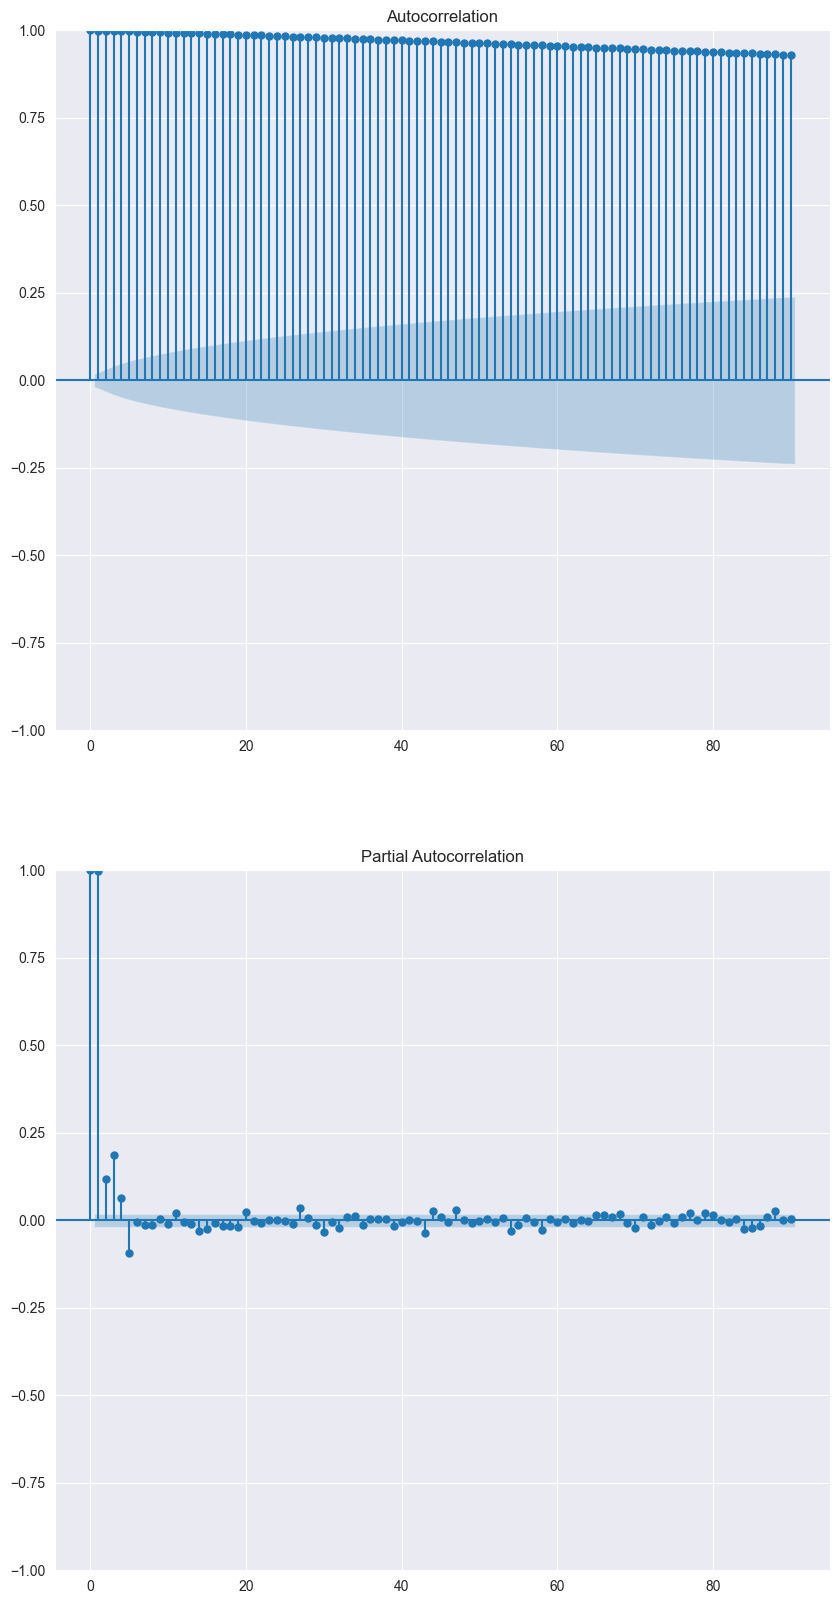

In [149]:
# identificando ACF e PACF
fig = plt.figure(figsize=(10, 20))

ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=90, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=90, ax=ax2)

#### ARIMA

In [150]:
# Ajustar o modelo ARIMA
model = ARIMA(treino['y'], order=(1, 1, 10))
model_fit = model.fit()

# Verificar os resultados
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                11267
Model:                ARIMA(1, 1, 10)   Log Likelihood              -19794.051
Date:                Fri, 15 Nov 2024   AIC                          39612.102
Time:                        14:54:26   BIC                          39700.057
Sample:                             0   HQIC                         39641.699
                              - 11267                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5986      0.172     -3.486      0.000      -0.935      -0.262
ma.L1          0.4388      0.171      2.562      0.010       0.103       0.774
ma.L2         -0.2627      0.028     -9.345      0.0

In [151]:
# Fazer previsões para a base de teste
forecast = model_fit.forecast(steps=len(teste))

# Exibir as previsões
print(forecast)

11267    72.622286
11268    72.283893
11269    72.059146
11270    72.160018
11271    72.182592
11272    72.151600
11273    72.151869
11274    72.188078
11275    72.197460
11276    72.191053
Name: predicted_mean, dtype: float64


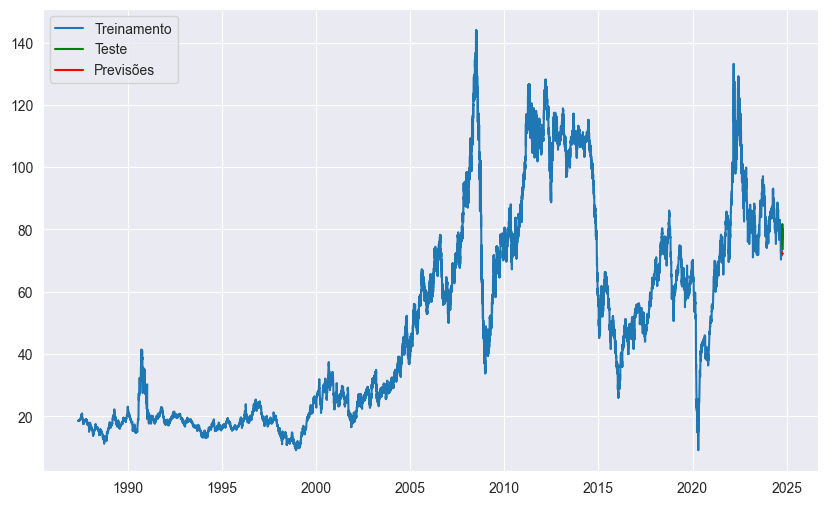

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(treino.index, treino['y'], label='Treinamento')
plt.plot(teste.index, teste['y'], label='Teste', color='green')
plt.plot(teste.index, forecast, label='Previsões', color='red')
plt.legend()
plt.show() 

In [156]:
mse = mean_squared_error(teste['y'], forecast)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

RMSE: 6.306897762038444


#### SARIMAX

In [158]:
model = SARIMAX(treino['y'], order=(1, 1, 1))

In [159]:
sarimax_model = model.fit()

In [170]:
forecast_sarimax = sarimax_model.predict(start=len(treino), end=len(treino) + len(teste) - 1)

In [171]:
mse_sarimax = mean_squared_error(teste['y'], forecast_sarimax)
rmse_sarimax = mse_sarimax ** 0.5
print(f'RMSE do modelo SARIMAX: {rmse_sarimax}')

RMSE do modelo SARIMAX: 5.963782264396538


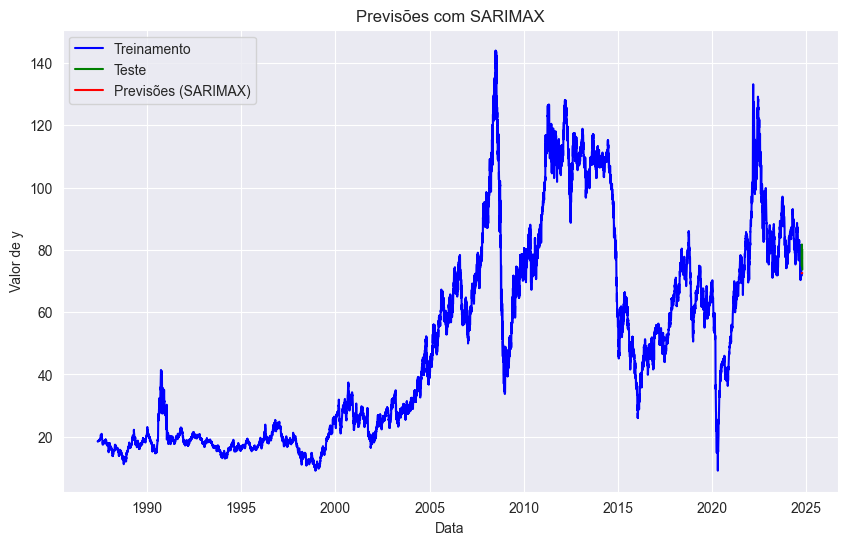

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(treino.index, treino['y'], label='Treinamento', color='blue')
plt.plot(teste.index, teste['y'], label='Teste', color='green')
plt.plot(teste.index, forecast_sarimax, label='Previsões (SARIMAX)', color='red')
plt.title('Previsões com SARIMAX')
plt.xlabel('Data')
plt.ylabel('Valor de y')
plt.legend()
plt.show()